# CS 3110/5110: Data Privacy
## Homework 5

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

## Question 1 (5 points)

Implement the `dp_occupation_histogram` function below. It should return a differentially private histogram over the `Occupation` column in the `adult` dataset. Your function should have a total privacy cost of `epsilon` and should use parallel composition.

In [2]:
def dp_occupation_histogram(epsilon):
    f = lambda x: laplace_mech(x, 1, epsilon)
    s = adult['Occupation'].value_counts().apply(f)
    return s

dp_occupation_histogram(1)

Occupation
Prof-specialty       4139.576901
Craft-repair         4099.884509
Exec-managerial      4065.413699
Adm-clerical         3770.757412
Sales                3651.130609
Other-service        3294.936775
Machine-op-inspct    2001.855916
Transport-moving     1593.678315
Handlers-cleaners    1370.311564
Farming-fishing       993.800865
Tech-support          928.817145
Protective-serv       654.015270
Priv-house-serv       147.707147
Armed-Forces            8.216604
Name: count, dtype: float64

In [3]:
# TEST CASE
hist = adult['Occupation'].value_counts()
dp_results = [np.abs(dp_occupation_histogram(1.0)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/1.0) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 2
assert stats.wasserstein_distance(all_dp_results, spec) > 0

dp_results = [np.abs(dp_occupation_histogram(0.01)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/0.01) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 150
assert stats.wasserstein_distance(all_dp_results, spec) > 50

## Question 2 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your solution for `dp_occupation_histogram` satisfies `epsilon`-differential privacy.
- How would your results change (in terms of accuracy) if you used sequential composition instead of parallel composition to implement `dp_occupation_histogram`, and why?
- If you partition the data by *both* occupation and age (i.e. a contingency table), would parallel composition still apply? Why or why not?
- If you partition the data by both occupation and age, what would happen to accuracy, and why?

- My solution for `dp_occupation_histogram` satisfies `epsilon`-differential privacy because it applies the laplace mechanism to individual occupations. This "binning" of data ensures that no one entry is accessed more than once.
- Parallel composition has the potential to give more inaccurate results than sequential composition. This is because by "binning" data, parallel composition uses smaller individual datasets, introducing a higher possibility for error.
- Yes, it would still work. It's sort of like subdividing a bin into even smaller bins.
- Accuracy would likely decrease because the count of entries in each bin would decrease.

## Question 3 (5 points)

Consider the code below, which graphs the total privacy cost of an averaging attack under (1) sequential composition and (2) advanced composition, for values of `k` between 1 and 200.

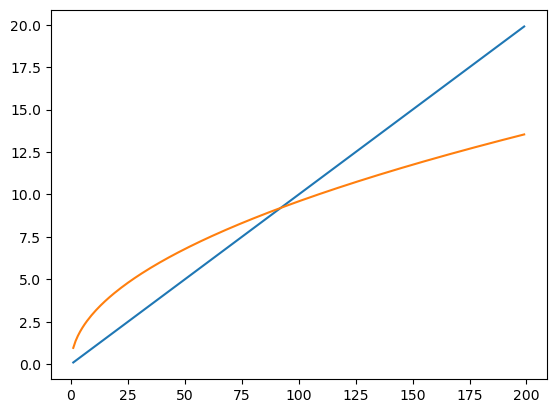

In [15]:
epsilon = .1
delta_p = 1e-5

def query():
    return len(adult[adult['Martial Status'] == 'Divorced'])

def avg_attack(k):
    return np.mean([laplace_mech(query(), 1, epsilon) for i in range(k)])
    
xs = range(1, 200)
privacy_cost_sequential = [k * epsilon for k in xs]
privacy_cost_advanced = [2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)) for k in xs]

# Straight line
plt.plot(xs, privacy_cost_sequential)
# Curves
plt.plot(xs, privacy_cost_advanced)

In 2-5 sentences, answer the following:
- At approximately what point do the lines representing the two approaches cross? What does this mean about **which** composition technique should be used for an iterative algorithm?
- The two lines represent **different** privacy costs for the **same** algorithm. How can both be correct?

- The lines representing the two approaches cross probably around x = 80. This means that sequential composition is more useful on lower $k$ applications while advanced composition becomes useful with more iterations.
- Both sequential and advanced composition are mechanisms that are used as part of the algorithm, not separate algorithms themselves

## Question 4 (10 points)

Consider the code below, which defines three average queries and runs them on `adult_data`, using the Laplace mechanism to provide differential privacy with $\epsilon = 1$ for each query.

In [5]:
b_capgain = 10000
b_age = 3000

epsilon = 1

def query1():
    return np.sum(adult['Capital Gain'].clip(lower=0, upper=b_capgain))

def query2():
    return len(adult[adult['Education-Num'] < 10])

def query3():
    return np.sum(adult['Age'].clip(lower=0, upper=b_age))

def my_query():
    return [query1(), query2(), query3()]

my_query()

[17145231, 14754, 1256257]

In 2-5 sentences, answer the following:
- What is the $L_1$ global sensitivity of `my_query`, and why?
- What is the $L_2$ global sensitivity of `my_query`, and why?

- The $L_1$ global sensitivity of `my_query` is 3 because it returns a vector of 3 1-sensitive results
- The $L_2$ global sensitivity of `my_query` is $\sqrt{3}$ because $L_2$ sensitivity is the square root of $L_1$ sensitivity.

## Question 5 (5 points)

In the cell below, write code to release the results of calling `my_query()` with differential privacy, without using sequential composition.

*Hint*: use `laplace_mech_vec`, but be careful of sensitivity!

In [16]:
def my_query_lap(epsilon):
    return laplace_mech_vec(my_query(), 3, epsilon)

my_query_lap(1.0)

[17145241.373756014, 14761.47362481454, 1256265.8802088192]

## Question 6 (5 points)

In the cell below, write code to release the results of `my_query()` with differential privacy, but using the Gaussian mechanism.

*Hint*: remember to use $L_2$ sensitivity

In [17]:
def my_query_gauss(epsilon, delta):
    return gaussian_mech_vec(my_query(), np.sqrt(3), epsilon, delta)

my_query_gauss(1.0, 1e-5)

[17145217.18531319, 14746.425223756563, 1256240.4461919463]